# PSQE Visualization

This notebook visualizes the Piecewise Smooth Quadratic Underestimator (PSQE).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
from psqe_bounds import PSQE_Bounds

# Ensure plots look nice
# plt.style.use('ggplot')

In [2]:
def get_lambdified_functions(func_str):
    """
    Parses a string function (e.g., 'sin(x)') and returns numpy-compatible
    functions for f(x), f'(x), and f''(x).
    """
    x = sympy.symbols('x')
    expr = sympy.sympify(func_str)
    
    f_sym = expr
    df_sym = sympy.diff(expr, x)
    d2f_sym = sympy.diff(expr, x, x)
    
    f = sympy.lambdify(x, f_sym, 'numpy')
    df = sympy.lambdify(x, df_sym, 'numpy')
    d2f = sympy.lambdify(x, d2f_sym, 'numpy')
    
    return f, df, d2f

def estimate_lipschitz_bounds(d2f, a, b, num_points=1000):
    """
    Estimates alpha (min f'') and beta (max f'') over [a, b] by sampling.
    """
    x_vals = np.linspace(a, b, num_points)
    y_vals = d2f(x_vals)
    
    # Handle case where d2f returns a scalar (constant 2nd derivative)
    if np.isscalar(y_vals):
        return y_vals, y_vals
    if y_vals.ndim == 0:
         return float(y_vals), float(y_vals)
         
    alp = np.min(y_vals)
    bet = np.max(y_vals)
    
    # For safety with the estimator formula, ensure bet > alp slightly if they are equal
    if bet == alp:
        bet += 1e-8
        
    return alp, bet

In [ ]:
def visualize_psqe(func_str, a, b):
    # 1. Prepare function and derivatives
    f, df, d2f = get_lambdified_functions(func_str)
    
    # 2. Evaluate boundary conditions
    fa = f(a)
    fb = f(b)
    dfa = df(a)
    dfb = df(b)
    
    # 3. Estimate alpha and beta
    alp, bet = estimate_lipschitz_bounds(d2f, a, b)
    print(f"Interval: [{a}, {b}]")
    print(f"Alpha (min f''): {alp:.4f}")
    print(f"Beta (max f''): {bet:.4f}")
    
    # 4. Create Estimator
    # The class PSQE_Bounds(a, b, alp, bet, fa, fb, dfa, dfb, under)
    estimator = PSQE_Bounds(a, b, alp, bet, fa, fb, dfa, dfb, under=True)
    
    c = estimator.c
    d = estimator.d
    print(f"Split point c: {c:.4f}")
    print(f"Split point d: {d:.4f}")
    
    # 5. Plotting
    # plt.figure(figsize=(10, 6))
    
    # Plot original function
    x_full = np.linspace(a, b, 500)
    plt.axhline(y=0, linestyle='--', color='black')
    plt.plot(x_full, f(x_full),'g-')
    
    # Plot Underestimator Segments
    # Segment 1: [a, c]
    if c > a:
        x1 = np.linspace(a, c, 100)
        y1 = estimator.q1(x1)
        plt.plot(x1, y1, 'b-')
    
    # Segment 2: [c, d]
    if d > c:
        x2 = np.linspace(c, d, 100)
        y2 = estimator.q2(x2)
        plt.plot(x2, y2, 'y-')
        
    # Segment 3: [d, b]
    if b > d:
        x3 = np.linspace(d, b, 100)
        y3 = estimator.q3(x3)
        plt.plot(x3, y3, 'r-')
        
    # Plot split points
    # Plot split points and bounds (vertical lines to x-axis)
    yc = estimator.estimator(c)
    yd = estimator.estimator(d)
    ya = estimator.estimator(a)
    yb = estimator.estimator(b)
    plt.vlines(x=[a, c, d, b], ymin=0, ymax=[ya, yc, yd, yb], colors='black', linestyles='--', alpha=0.5)
    plt.scatter([c, d], [yc, yd], color='black', zorder=5)
    
    # plt.title(f"PSQE Underestimator for {func_str}")
    # plt.legend()
    # plt.grid(True)
    plt.savefig('./psqe_vis.png', dpi=500)
    plt.show()

Interval: [-5.0, 5.0]
Alpha (min f''): -2.3816
Beta (max f''): 5.0783
Split point c: -1.7864
Split point d: 1.7864


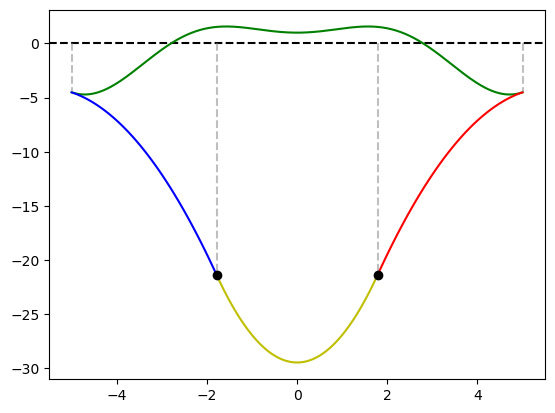

In [4]:
# Example Usage
func_string = "sin(x) * x + cos(x)"
interval_a = -5.0
interval_b = 5.0

visualize_psqe(func_string, interval_a, interval_b)

Interval: [-2.0, 2.0]
Alpha (min f''): -8.0000
Beta (max f''): 40.0000
Split point c: -0.6667
Split point d: 0.6667


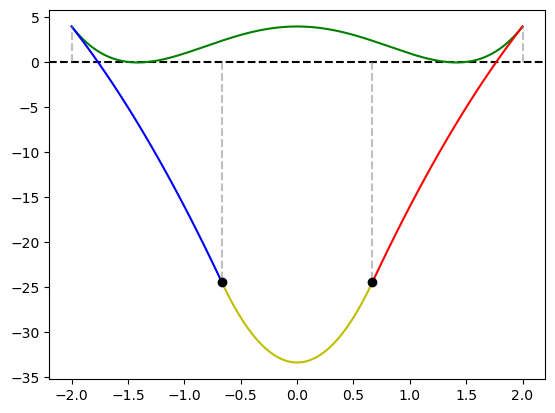

In [5]:
# Another Example
func_string = "(x**2 - 2)**2"
interval_a = -2.0
interval_b = 2.0

visualize_psqe(func_string, interval_a, interval_b)

Interval: [-1.5, 1.5]
Alpha (min f''): -7.0000
Beta (max f''): 11.0000
Split point c: -0.2500
Split point d: 1.2500


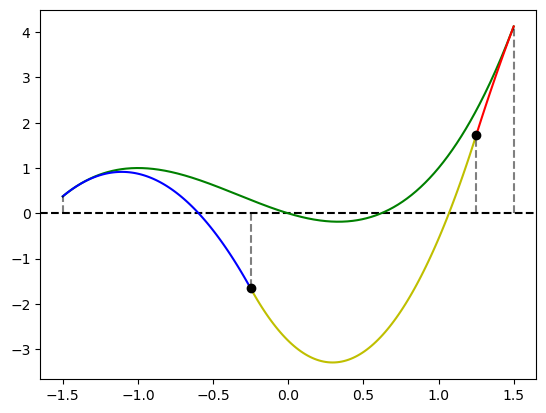

In [8]:

func_string = "x**3+x**2-x"
interval_a = -1.5
interval_b = 1.5

visualize_psqe(func_string, interval_a, interval_b)